# RFE with Google Analytics Data

Bu çalışmada, RFE (Recency, Frequency, Engagement) analizini kullanarak davranışa dayalı müşteri segmentleri oluşturmak için KMeans kümelemesini kullanır. RFE analizi, müşteri davranışını ölçmek için kullanılan RFM (Recency, Frequency, Monetary) pazarlama modelinin bir varyasyonudur. Bu projede kullanılan belirli veri kümesi için, Recency, kullanıcının sitedeki en son tıkladığı zaman, Frequency, kullanıcının toplam tıklama sayısı ve Engagement, kullanıcının sitedeki toplam geçiriği zaman olarak tanımlanır.

Google Analytics veriseti Bigquery'de bulunan public bir verisetidir. Bu verisetini kullanmak için yapılması gereken bazı adımlarını bu medium yazısında bulabilirsiniz. [Medium Yazısı](https://towardsdatascience.com/access-free-google-cloud-public-dataset-with-python-42eb378be72c)

Verisetine dair bilgileri google dokümantasyonunda bulabilirsiniz. [Dokümantasyon](https://support.google.com/analytics/answer/3437719?hl=tr)

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify


from google.cloud import bigquery

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:\\Users\\user\\Desktop\\RFE-with-Google-Analytics-Data\\SA\\daring-keep-245611-d3e2f861c3a9.json"
client = bigquery.Client()        

Google Analytics veri seti normal bildiğiniz tablolara benzememektedir. Verileriniz, sütunların tek bir veri biti içerebileceği JSON nesnelerine biraz daha benzeyen satırlardan oluşur, ancak bunlar ayrıca diziler, yapılar ve hatta yapı dizileri içerebilir. Tablo yapısı aşağıdaki görsel ile daha açıklayıcı olabilir.

![Table Schema](img/TableSchema.png)

Bu tablo yapısının püf noktalarını ve sql sorgusundaki farklı syntax'ları anlayabilmek için aşağıdaki medium yazısını okuyabilirsiniz. [Medium Yazısı](https://medium.com/firebase-developers/using-the-unnest-function-in-bigquery-to-analyze-event-parameters-in-analytics-fb828f890b42)

In [3]:
query = """
        SELECT 
            t1.*,
            hits.*,
            hits.page.*
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` t1,
                UNNEST(hits) AS hits
        --WHERE fullVisitorID = '7194065619159478122'
        LIMIT 10
        """

result = client.query(query).result().to_dataframe()
result.head() 


,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,...,publisher_infos,pagePath,hostname,pageTitle,searchKeyword,searchCategory,pagePathLevel1,pagePathLevel2,pagePathLevel3,pagePathLevel4
0,NaN,1,1470117657,1470117657,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]",...,[],/home,shop.googlemerchandisestore.com,Home,None,None,/home,,,
1,NaN,1,1470117657,1470117657,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]",...,[],/google+redesign/gift+cards,shop.googlemerchandisestore.com,Gift Cards,None,None,/google+redesign/,/gift+cards,,
2,NaN,1,1470117657,1470117657,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]",...,[],/signin.html,shop.googlemerchandisestore.com,The Google Merchandise Store - Log In,None,None,/signin.html,,,
3,NaN,151,1470083489,1470083489,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]",...,[],/home,shop.googlemerchandisestore.com,Home,None,None,/home,,,
4,NaN,151,1470083489,1470083489,20160801,"{'visits': 1, 'hits': 3, 'pageviews': 3, 'time...","{'referralPath': '/yt/about/', 'campaign': '(n...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]",...,[],/google+redesign/apparel/men++s/men++s+t+shirts,shop.googlemerchandisestore.com,Men's-T-Shirts,None,None,/google+redesign/,/apparel/,/men++s/,/men++s+t+shirts


In [4]:
query = """
        SELECT 
            t1.fullVisitorID as USERID,
            t1.date as DATE,
            TIMESTAMP_ADD(TIMESTAMP_SECONDS(t1.visitStartTime), INTERVAL -7 HOUR) as visitStartTime,
            totals.hits,
            t1.totals.pageviews,
            t1.totals.timeOnSite, --Saniye cinsinden toplam oturum süresi.
            hits.page.pagePath,
            hits.hitNumber,
            hits.time,
            hits.hour,
            hits.minute
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` t1,
                UNNEST(hits) AS hits
        """

result = client.query(query).result().to_dataframe()
result.head()


,USERID,DATE,visitStartTime,hits,pageviews,timeOnSite,pagePath,hitNumber,time,hour,minute
0,7194065619159478122,20160801,2016-08-01 23:00:57+00:00,3,3,54.0,/home,1,0,23,0
1,7194065619159478122,20160801,2016-08-01 23:00:57+00:00,3,3,54.0,/google+redesign/gift+cards,2,30507,23,1
2,7194065619159478122,20160801,2016-08-01 23:00:57+00:00,3,3,54.0,/signin.html,3,53670,23,1
3,8159312408158297118,20160801,2016-08-01 13:31:29+00:00,3,3,529.0,/home,1,0,13,31
4,8159312408158297118,20160801,2016-08-01 13:31:29+00:00,3,3,529.0,/google+redesign/apparel/men++s/men++s+t+shirts,2,289206,13,36


In [3]:
query = """
        SELECT 
            fullVisitorID as USERID,
            TIMESTAMP_ADD(TIMESTAMP_SECONDS(visitStartTime), INTERVAL -7 HOUR) as visitStartTime,
            totals.hits,
            totals.timeOnSite --Saniye cinsinden toplam oturum süresi.

        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        """

result = client.query(query).result().to_dataframe()
result.head()


,USERID,visitStartTime,hits,timeOnSite
0,5347587558752623920,2016-09-07 08:09:07+00:00,1,NaN
1,021252403801883423,2016-09-07 12:32:30+00:00,1,NaN
2,7848565144687402733,2016-09-07 09:58:04+00:00,1,NaN
3,6715733239267261214,2016-09-07 06:50:38+00:00,1,NaN
4,7846775783089823005,2016-09-07 23:31:16+00:00,1,NaN


In [4]:
result['timeOnSite'] = result['timeOnSite'].fillna(0)

In [5]:
result['visitStartDate'] = result['visitStartTime'].dt.date

In [6]:
prep_df = result.groupby(by=['USERID','visitStartDate']).aggregate({'hits':'sum',
                                                                    'timeOnSite':'sum'})\
                                                        .reset_index()\
                                                        .rename(columns={'hits':'total_click','timeOnSite':'total_time'})

In [7]:
prep_df.head()

,USERID,visitStartDate,total_click,total_time
0,0000010278554503158,2016-10-20,11,194.0
1,0000020424342248747,2016-12-01,17,297.0
2,0000027376579751715,2017-02-11,6,49.0
3,0000039460501403861,2017-03-27,2,99.0
4,0000040862739425590,2017-02-11,5,49.0


In [8]:
max_date = prep_df['visitStartDate'].max()

recency_df = prep_df[['USERID','visitStartDate']] \
                        .groupby('USERID') \
                        .apply(lambda x: (max_date - x['visitStartDate'].max()) / pd.to_timedelta(1,'d')) \
                        .to_frame() \
                        .set_axis(["recency"],axis=1)

In [9]:
recency_df.head()

,recency
USERID,
0000010278554503158,285.0
0000020424342248747,243.0
0000027376579751715,171.0
0000039460501403861,127.0
0000040862739425590,171.0


In [10]:
frequency_df = prep_df.groupby('USERID') \
                 .aggregate({'total_click' : 'sum'}) \
                 .set_axis(["frequency"],axis=1)

In [11]:
frequency_df.head()

,frequency
USERID,
0000010278554503158,11
0000020424342248747,17
0000027376579751715,6
0000039460501403861,2
0000040862739425590,5


In [12]:
engagement_df = prep_df.groupby('USERID') \
                 .aggregate({'total_time' : 'sum'}) \
                 .set_axis(["engagement"],axis=1)

In [13]:
engagement_df.head()

,engagement
USERID,
0000010278554503158,194.0
0000020424342248747,297.0
0000027376579751715,49.0
0000039460501403861,99.0
0000040862739425590,49.0


In [14]:
rfm_table = pd.concat([recency_df,frequency_df,engagement_df], axis= 1).fillna(0)
rfm_table.rename(columns= {'recency': 'Recency',
                          'frequency': 'Frequency',
                          'engagement': 'Engagement'}, inplace= True)

In [15]:
rfm_table.head()

,Recency,Frequency,Engagement
USERID,,,
0000010278554503158,285.0,11,194.0
0000020424342248747,243.0,17,297.0
0000027376579751715,171.0,6,49.0
0000039460501403861,127.0,2,99.0
0000040862739425590,171.0,5,49.0


In [16]:
rfm_table['recency_tile'] = pd.qcut(rfm_table['Recency'], q = 5, labels=[5,4,3,2,1])
rfm_table['engagement_tile'] = pd.qcut(rfm_table['Engagement'].rank(method='first'), q = 5, labels=[1,2,3,4,5])
rfm_table['frequency_tile'] = pd.qcut(rfm_table['Frequency'].rank(method='first'), q = 5, labels=[1,2,3,4,5])

In [17]:
rfm_table.head()

,Recency,Frequency,Engagement,recency_tile,engagement_tile,frequency_tile
USERID,,,,,,
0000010278554503158,285.0,11,194.0,2,5,5
0000020424342248747,243.0,17,297.0,3,5,5
0000027376579751715,171.0,6,49.0,3,4,4
0000039460501403861,127.0,2,99.0,4,4,3
0000040862739425590,171.0,5,49.0,3,4,4


In [18]:
rfm_table['RFM_Score'] = rfm_table['recency_tile'].astype(str) \
                            + rfm_table['frequency_tile'].astype(str) \
                            + rfm_table['engagement_tile'].astype(str)

<AxesSubplot:>

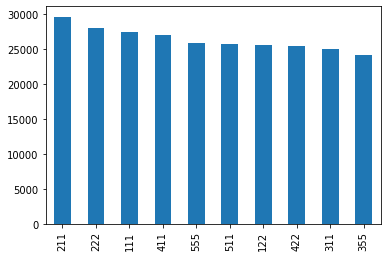

In [19]:
rfm_table['RFM_Score'].value_counts()[:10].plot(kind='bar')

In [20]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm_table['Segment'] = rfm_table['recency_tile'].astype(str) + rfm_table['frequency_tile'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table.head()

,Recency,Frequency,Engagement,recency_tile,engagement_tile,frequency_tile,RFM_Score,Segment
USERID,,,,,,,,
0000010278554503158,285.0,11,194.0,2,5,5,255,can't loose
0000020424342248747,243.0,17,297.0,3,5,5,355,loyal customers
0000027376579751715,171.0,6,49.0,3,4,4,344,loyal customers
0000039460501403861,127.0,2,99.0,4,4,3,434,potential loyalists
0000040862739425590,171.0,5,49.0,3,4,4,344,loyal customers


In [21]:
df_treemap = rfm_table.reset_index().groupby('Segment').agg(
    customers=('USERID', 'count')
).reset_index()

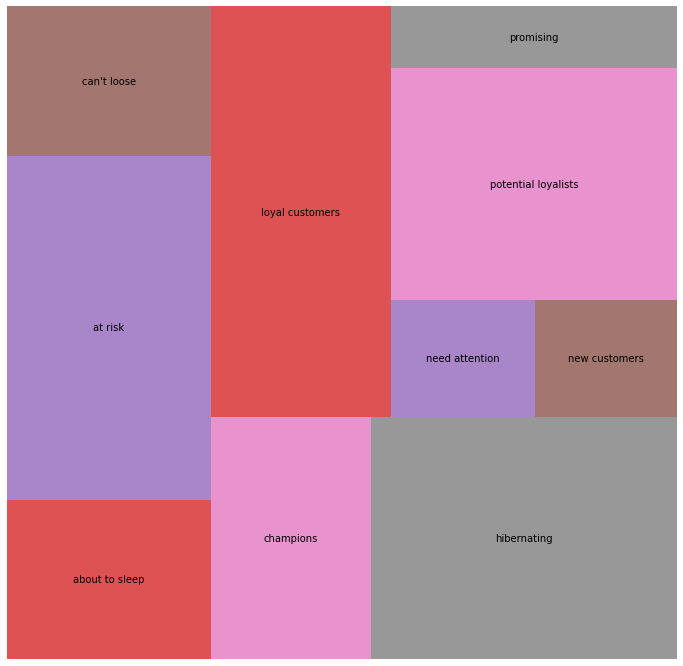

In [22]:
fig, ax = plt.subplots(1, figsize = (12,12))

squarify.plot(sizes=df_treemap['customers'], 
              label=df_treemap['Segment'], 
              alpha=.8,
              color=['tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
             )
plt.axis('off')
plt.show()

In [23]:
rfm_table = rfm_table.reset_index()
user_score = rfm_table[['USERID','Segment']]

In [24]:
query = """
        SELECT 
            fullVisitorID as USERID,
            SUM(totals.transactions) AS transactions,
            SUM(totals.totalTransactionRevenue)/1000000 AS total_revenue
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                 UNNEST(hits) AS hits
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
        GROUP BY USERID
        ORDER BY total_revenue DESC
        """

result2 = client.query(query).result().to_dataframe()
result2.head()

,USERID,transactions,total_revenue
0,1957458976293878100,1467.0,9430764.76
1,3924372865099736100,3000.0,4613870.00
2,9417857471295131045,869.0,3487745.46
3,9264804092676520813,2353.0,2484305.99
4,5632276788326171571,136.0,2180454.00
5,8942866004645538967,2702.0,1457458.80
6,5526675926038480325,12500.0,969045.00
7,3244885836845029978,290.0,795070.18
8,6226617329849661943,222.0,773636.70
9,9089132392240687728,886.0,745009.52


In [25]:
df = user_score.merge(result2, how='left', on='USERID')

In [30]:
df = df.fillna(0)

In [31]:
df.groupby(['Segment']).sum()

,transactions,total_revenue
Segment,,
about to sleep,0.0,0.00
at risk,6.0,168.06
can't loose,156476.0,32004440.03
champions,119703.0,34401363.30
hibernating,0.0,0.00
loyal customers,222174.0,36676830.71
need attention,0.0,0.00
new customers,0.0,0.00
potential loyalists,0.0,0.00
